In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from utils import automated_pipeline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [24]:
file_raw = r'E:\airta drafts\PREDIKSI KADAR HB\data\raw\erm_hd.xlsx'
df_raw = pd.read_excel(file_raw)

df = automated_pipeline(df_raw)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_pasien        639 non-null    int64         
 1   tgl_pemeriksaan  639 non-null    datetime64[ns]
 2   usia             639 non-null    Int64         
 3   jk               639 non-null    Int64         
 4   eritrosit        639 non-null    float64       
 5   hematokrit       639 non-null    float64       
 6   MCHC             639 non-null    float64       
 7   MCH              639 non-null    float64       
 8   MCV              639 non-null    float64       
 9   hemoglobin       639 non-null    float64       
 10  leukosit         639 non-null    Int64         
 11  trombosit        639 non-null    Int64         
 12  epo              639 non-null    Int64         
dtypes: Int64(5), datetime64[ns](1), float64(6), int64(1)
memory usage: 68.1 KB


In [25]:
df = df.sort_values(by=['id_pasien', 'tgl_pemeriksaan']).reset_index(drop=True)

#LAG FEATURE 
df['hb_lag'] = df.groupby('id_pasien')['hemoglobin'].shift(1)
df['hb_lag2'] = df.groupby('id_pasien')['hemoglobin'].shift(2)

df['hb_delta'] = df['hb_lag'] - df['hb_lag2']

df['inflamasi'] = (df['leukosit'] / 10000) * (df['trombosit'] / 150000)
df['epo_resist'] = df['epo'] / (df['inflamasi'] + 1)

lag_cols = ['hb_lag', 'hb_lag2']
df = df.dropna(subset=lag_cols).reset_index(drop=True)

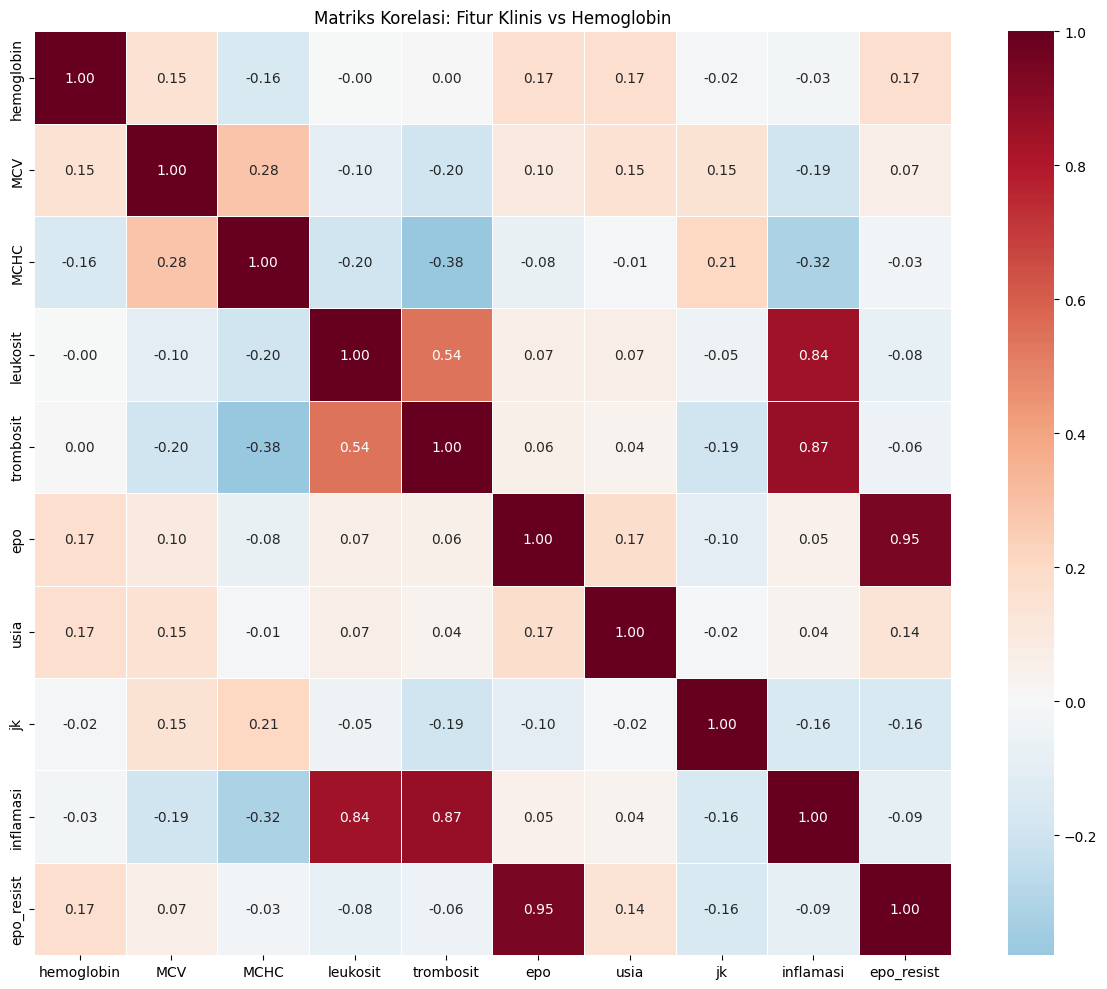

In [26]:
cols_to_corr = [
    'hemoglobin', 'MCV', 'MCHC', 'leukosit', 'trombosit',
    'epo', 'usia', 'jk', 'inflamasi', 'epo_resist'
]

corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5)

plt.title("Matriks Korelasi: Fitur Klinis vs Hemoglobin")
plt.tight_layout()
plt.show()

In [27]:
#MENENTUKAN FITUR X DAN TARGET Y
X = df.drop(columns=['id_pasien', 'tgl_pemeriksaan', 'hemoglobin', 'hematokrit', 'eritrosit', 'MCH', 'epo', 'inflamasi'])
y = df['hemoglobin']

#SPLIT 80:20 BERDASARKAN KRONOLOGIS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False
)

print(f"Total baris data: {len(df)}")
print(f"Jumlah Data Latih (80%): {len(X_train)}")
print(f"Jumlah Data Uji (20%): {len(X_test)}")
print("-" * 30)
print("Fitur yang digunakan (X):", X.columns.tolist())

Total baris data: 497
Jumlah Data Latih (80%): 397
Jumlah Data Uji (20%): 100
------------------------------
Fitur yang digunakan (X): ['usia', 'jk', 'MCHC', 'MCV', 'leukosit', 'trombosit', 'hb_lag', 'hb_lag2', 'hb_delta', 'epo_resist']


In [28]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

print(f"Total baris di X_train: {len(X_train)}")
print("-" * 30)

for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
    print(f"Iterasi ke-{i+1}:")
    print(f"  Jumlah Data Latih: {len(train_index)} baris (Indeks {train_index[0]} s/d {train_index[-1]})")
    print(f"  Jumlah Data Validasi: {len(val_index)} baris (Indeks {val_index[0]} s/d {val_index[-1]})")
    print("-" * 30)

Total baris di X_train: 397
------------------------------
Iterasi ke-1:
  Jumlah Data Latih: 67 baris (Indeks 0 s/d 66)
  Jumlah Data Validasi: 66 baris (Indeks 67 s/d 132)
------------------------------
Iterasi ke-2:
  Jumlah Data Latih: 133 baris (Indeks 0 s/d 132)
  Jumlah Data Validasi: 66 baris (Indeks 133 s/d 198)
------------------------------
Iterasi ke-3:
  Jumlah Data Latih: 199 baris (Indeks 0 s/d 198)
  Jumlah Data Validasi: 66 baris (Indeks 199 s/d 264)
------------------------------
Iterasi ke-4:
  Jumlah Data Latih: 265 baris (Indeks 0 s/d 264)
  Jumlah Data Validasi: 66 baris (Indeks 265 s/d 330)
------------------------------
Iterasi ke-5:
  Jumlah Data Latih: 331 baris (Indeks 0 s/d 330)
  Jumlah Data Validasi: 66 baris (Indeks 331 s/d 396)
------------------------------


In [29]:
df_check = df.copy()
df_check['set'] = 'train'
df_check.loc[X_test.index, 'set'] = 'test'

df_check[['id_pasien', 'tgl_pemeriksaan', 'hb_lag', 'hb_lag2', 'hemoglobin', 'set']].iloc[
    len(X_train)-5 : len(X_train)+5
]

,id_pasien,tgl_pemeriksaan,hb_lag,hb_lag2,hemoglobin,set
392,53,2025-10-01,9.3,8.6,8.6,train
393,53,2025-11-01,8.6,9.3,7.0,train
394,53,2025-12-01,7.0,8.6,8.6,train
395,53,2026-01-01,8.6,7.0,7.7,train
396,54,2025-05-01,7.3,8.4,7.6,train
397,54,2025-06-01,7.6,7.3,8.6,test
398,54,2025-07-01,8.6,7.6,9.5,test
399,54,2025-08-01,9.5,8.6,9.0,test
400,54,2025-09-01,9.0,9.5,8.2,test
401,54,2025-10-01,8.2,9.0,8.5,test


In [30]:
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

def obj_svr(trial):
    c = trial.suggest_float('C', 0.1, 100.0, log=True)
    epsilon = trial.suggest_float('epsilon', 0.01, 1.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(
            C=c,
            epsilon=epsilon,
            gamma=gamma,
            kernel='rbf'
        ))
    ])

    score = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


def obj_rf(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth=trial.suggest_int('max_depth', 3, 15),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        random_state=42
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


def obj_lgbm(trial):
    model = LGBMRegressor(
        n_estimators=trial.suggest_int('n_estimators', 20, 100), 
        max_depth=trial.suggest_int('max_depth', 2, 4),
        num_leaves=trial.suggest_int('num_leaves', 4, 15),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1),
        lambda_l1=trial.suggest_float('lambda_l1', 0.1, 10.0, log=True),
        lambda_l2=trial.suggest_float('lambda_l2', 0.1, 10.0, log=True),
        min_child_samples=trial.suggest_int('min_child_samples', 20, 50),
        feature_fraction=trial.suggest_float('feature_fraction', 0.5, 0.8),
        
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )

    score = cross_val_score(
        model, X_train, y_train, 
        cv=tscv, 
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()

def obj_xgb(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 8),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


# --- EKSEKUSI TUNING  ---

print("Menjalankan Tuning SVR...")
study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(obj_svr, n_trials=30)

print("Menjalankan Tuning Random Forest...")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(obj_rf, n_trials=30)

print("Menjalankan Tuning LightGBM...")
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(obj_lgbm, n_trials=30)

print("Menjalankan Tuning XGBoost...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(obj_xgb, n_trials=30)

print("\n--- TUNING SELESAI ---")
print(f"SVR MAE: {-study_svr.best_value:.4f}")
print(f"RF MAE: {-study_rf.best_value:.4f}")
print(f"LGBM MAE: {-study_lgbm.best_value:.4f}")
print(f"XGB MAE: {-study_xgb.best_value:.4f}")

[I 2026-03-01 13:48:34,898] A new study created in memory with name: no-name-1ed19b47-643d-49bc-8cea-6c7863b44585
[I 2026-03-01 13:48:35,096] Trial 0 finished with value: 0.8750853595844698 and parameters: {'C': 14.29367459173382, 'epsilon': 0.014755290371302963, 'gamma': 0.2512473292278482}. Best is trial 0 with value: 0.8750853595844698.


Menjalankan Tuning SVR...


[I 2026-03-01 13:48:35,235] Trial 1 finished with value: 0.7383163547444501 and parameters: {'C': 7.458290835810238, 'epsilon': 0.011490944568765402, 'gamma': 0.0002470924742702946}. Best is trial 1 with value: 0.7383163547444501.
[I 2026-03-01 13:48:35,344] Trial 2 finished with value: 0.6574560667614101 and parameters: {'C': 4.038275549819459, 'epsilon': 0.287281576591734, 'gamma': 0.00247734933527494}. Best is trial 2 with value: 0.6574560667614101.
[I 2026-03-01 13:48:35,454] Trial 3 finished with value: 0.7828547629526614 and parameters: {'C': 0.2830670339811974, 'epsilon': 0.1425673137322847, 'gamma': 0.20338907361603487}. Best is trial 2 with value: 0.6574560667614101.
[I 2026-03-01 13:48:35,613] Trial 4 finished with value: 0.914989816373399 and parameters: {'C': 7.540928868657888, 'epsilon': 0.015902370808696772, 'gamma': 0.7856289126022765}. Best is trial 2 with value: 0.6574560667614101.
[I 2026-03-01 13:48:35,713] Trial 5 finished with value: 0.9137802801655935 and paramete

Menjalankan Tuning Random Forest...


[I 2026-03-01 13:48:43,116] Trial 0 finished with value: 0.6653326242823303 and parameters: {'n_estimators': 181, 'max_depth': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6653326242823303.
[I 2026-03-01 13:48:45,753] Trial 1 finished with value: 0.6874575139888115 and parameters: {'n_estimators': 101, 'max_depth': 12, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6653326242823303.
[I 2026-03-01 13:48:49,020] Trial 2 finished with value: 0.6806716579332681 and parameters: {'n_estimators': 187, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6653326242823303.
[I 2026-03-01 13:48:52,896] Trial 3 finished with value: 0.6959143953618503 and parameters: {'n_estimators': 235, 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6653326242823303.
[I 2026-03-01 13:48:57,647] Trial 4 finished with value: 0.692306675476976 and parameters: {'n_estimators': 290, 'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.66533262

Menjalankan Tuning LightGBM...


[I 2026-03-01 13:50:31,655] Trial 1 finished with value: 0.7936202983258681 and parameters: {'n_estimators': 45, 'max_depth': 3, 'num_leaves': 14, 'learning_rate': 0.021313332412446852, 'lambda_l1': 1.5482833293734337, 'lambda_l2': 0.13908813821596375, 'min_child_samples': 36, 'feature_fraction': 0.6135343413767205}. Best is trial 0 with value: 0.7448222650453103.
[I 2026-03-01 13:50:31,822] Trial 2 finished with value: 0.6924000754338542 and parameters: {'n_estimators': 46, 'max_depth': 3, 'num_leaves': 11, 'learning_rate': 0.060543852605347975, 'lambda_l1': 0.12354505601132554, 'lambda_l2': 0.21111401493727322, 'min_child_samples': 25, 'feature_fraction': 0.5618465465508511}. Best is trial 2 with value: 0.6924000754338542.
[I 2026-03-01 13:50:31,965] Trial 3 finished with value: 0.689759550770791 and parameters: {'n_estimators': 39, 'max_depth': 4, 'num_leaves': 5, 'learning_rate': 0.07137046531049712, 'lambda_l1': 0.43241843757331483, 'lambda_l2': 0.17691071912312195, 'min_child_sam

Menjalankan Tuning XGBoost...


[I 2026-03-01 13:50:37,747] Trial 0 finished with value: 0.7215144950772119 and parameters: {'n_estimators': 106, 'learning_rate': 0.021216343006738504, 'max_depth': 5, 'subsample': 0.6163604699906918, 'colsample_bytree': 0.6091273059058704}. Best is trial 0 with value: 0.7215144950772119.
[I 2026-03-01 13:50:38,458] Trial 1 finished with value: 0.7361497699450308 and parameters: {'n_estimators': 69, 'learning_rate': 0.02645091489483605, 'max_depth': 8, 'subsample': 0.6161969466872068, 'colsample_bytree': 0.7695504336549158}. Best is trial 0 with value: 0.7215144950772119.
[I 2026-03-01 13:50:39,239] Trial 2 finished with value: 0.746855624437989 and parameters: {'n_estimators': 119, 'learning_rate': 0.04812559440811794, 'max_depth': 4, 'subsample': 0.8630666760608795, 'colsample_bytree': 0.9030715637274742}. Best is trial 0 with value: 0.7215144950772119.
[I 2026-03-01 13:50:40,205] Trial 3 finished with value: 0.7470249720854536 and parameters: {'n_estimators': 191, 'learning_rate': 


--- TUNING SELESAI ---
SVR MAE: -0.6409
RF MAE: -0.6623
LGBM MAE: -0.6735
XGB MAE: -0.7030


In [31]:
# CEK HASIL BEST PARAMETERS DARI SEMUA MODEL

studies = {
    "SVR": study_svr,
    "Random Forest": study_rf,
    "LightGBM": study_lgbm,
    "XGBoost": study_xgb
}

print("=== RINGKASAN PARAMETER TERBAIK (OPTUNA) ===\n")

for model_name, study in studies.items():
    print(f"--- {model_name} ---")
    params = study.best_params
    
    for param_name, param_value in params.items():
        if isinstance(param_value, float):
            print(f"  > {param_name}: {param_value:.4f}")
        else:
            print(f"  > {param_name}: {param_value}")
            
    print(f"  > Best CV MAE Score: {study.best_value:.4f}")
    print("-" * 30)

import pandas as pd
df_params = pd.DataFrame([
    {"Model": k, "Best MAE": v.best_value, **v.best_params} 
    for k, v in studies.items()
])
print("\nDataFrame Parameter:")

=== RINGKASAN PARAMETER TERBAIK (OPTUNA) ===

--- SVR ---
  > C: 8.4606
  > epsilon: 0.0241
  > gamma: 0.0037
  > Best CV MAE Score: 0.6409
------------------------------
--- Random Forest ---
  > n_estimators: 293
  > max_depth: 3
  > min_samples_leaf: 9
  > Best CV MAE Score: 0.6623
------------------------------
--- LightGBM ---
  > n_estimators: 73
  > max_depth: 3
  > num_leaves: 15
  > learning_rate: 0.0811
  > lambda_l1: 0.4167
  > lambda_l2: 0.3354
  > min_child_samples: 20
  > feature_fraction: 0.7259
  > Best CV MAE Score: 0.6735
------------------------------
--- XGBoost ---
  > n_estimators: 243
  > learning_rate: 0.0136
  > max_depth: 3
  > subsample: 0.6772
  > colsample_bytree: 0.9668
  > Best CV MAE Score: 0.7030
------------------------------

DataFrame Parameter:


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Inisialisasi Model Final dengan Best Parameters dari Optuna
models_final = {}

# Linear Regression
models_final["Linear Regression (Baseline)"] = LinearRegression()

# SVR
svr_params = study_svr.best_params
models_final["SVR"] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(
        C=svr_params['C'],
        epsilon=svr_params['epsilon'],
        gamma=svr_params['gamma'],
        kernel='rbf'
    ))
])

# Random Forest
models_final["Random Forest"] = RandomForestRegressor(
    **study_rf.best_params,
    random_state=42
)

# LightGBM
models_final["LightGBM"] = LGBMRegressor(
    **study_lgbm.best_params,
    random_state=42,
    verbose=-1
)

# XGBoost
xgb_params = study_xgb.best_params.copy()
xgb_params['random_state'] = 42
models_final["XGBoost"] = XGBRegressor(**xgb_params)


# 2. Proses Training Final & Evaluasi di Data Test (20%)
final_results = []

for name, model in models_final.items():
    # Training menggunakan 80% data
    model.fit(X_train, y_train)
    
    # Prediksi menggunakan 20% data uji
    y_pred = model.predict(X_test)
    
    # Perhitungan Metrik Evaluasi
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    final_results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

df_final = pd.DataFrame(final_results).sort_values(by="MAE")
print(df_final)

                          Model       MAE      RMSE        R2
3                      LightGBM  0.653938  0.827798  0.440453
4                       XGBoost  0.676286  0.844150  0.418129
2                 Random Forest  0.686194  0.857300  0.399859
1                           SVR  0.724791  0.892230  0.349959
0  Linear Regression (Baseline)  0.729648  0.905066  0.331120


In [33]:
from sklearn.model_selection import cross_val_score

cv_results = []

for name, model in models_final.items():
    
    cv_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    
    cv_mae = -cv_scores.mean()
    
    cv_results.append({
        "Model": name,
        "CV_MAE": cv_mae
    })

df_cv = pd.DataFrame(cv_results)
print(df_cv)


                          Model    CV_MAE
0  Linear Regression (Baseline)  0.652478
1                           SVR  0.640942
2                 Random Forest  0.662337
3                      LightGBM  0.673459
4                       XGBoost  0.702978


In [34]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(models_final["LightGBM"], X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
mae_per_fold = -cv_scores

print("MAE per Fold untuk LightGBM:")
for i, mae in enumerate(mae_per_fold):
    print(f"Fold {i+1}: {mae:.4f}")

print(f"\nRata-rata MAE: {mae_per_fold.mean():.4f}")
print(f"Standar Deviasi: {mae_per_fold.std():.4f}")

MAE per Fold untuk LightGBM:
Fold 1: 0.6678
Fold 2: 0.8273
Fold 3: 0.5725
Fold 4: 0.6149
Fold 5: 0.6847

Rata-rata MAE: 0.6735
Standar Deviasi: 0.0866


In [35]:
from sklearn.inspection import permutation_importance
  
result = permutation_importance(models_final['LightGBM'], X_test, y_test, n_repeats=10, random_state=42)

importance_lgbm = pd.DataFrame({
    'Fitur': X_train.columns,
    'Importance_Mean': result.importances_mean
}).sort_values(by='Importance_Mean', ascending=False)

print(importance_lgbm)

        Fitur  Importance_Mean
6      hb_lag         0.428003
7     hb_lag2         0.069294
3         MCV         0.028097
2        MCHC         0.020002
8    hb_delta         0.008910
4    leukosit         0.003686
1          jk         0.002328
0        usia         0.001984
5   trombosit         0.000680
9  epo_resist         0.000365


In [49]:
df_eval['err_lag'] = abs(df_eval['y_actual'] - df_eval['pred_lag_only'])
df_eval['err_full'] = abs(df_eval['y_actual'] - df_eval['pred_full_model'])

# Filter data khusus pengguna EPO (epo_resist > 0)
df_epo_users = df_eval[df_eval['epo_resist'] > 0].copy()

# Filter data yang tidak stabil (Anomali > 1.0)
df_kritis_epo = df_epo_users[abs(df_epo_users['perubahan_asli']) > 1.0].copy()

if len(df_kritis_epo) > 0:
    mae_lag_kritis = df_kritis_epo['err_lag'].mean()
    mae_full_kritis = df_kritis_epo['err_full'].mean()

    print(f"Ditemukan {len(df_kritis_epo)} pasien kritis yang menggunakan EPO")
    print("-" * 50)
    print(df_kritis_epo[['y_actual', 'hb_lag', 'perubahan_asli', 'pred_full_model', 'err_full', 'err_lag']].head(10))
    print(f"MAE (Hanya Hb Lag)        : {mae_lag_kritis:.4f}")
    print(f"MAE (Full Model + epo_res): {mae_full_kritis:.4f}")

    improvement = ((mae_lag_kritis - mae_full_kritis) / mae_lag_kritis) * 100
    print(f"Peningkatan Akurasi Kelompok EPO: {improvement:.2f}%")
    win = (df_kritis_epo['err_full'] < df_kritis_epo['err_lag']).sum()
    loss = (df_kritis_epo['err_full'] > df_kritis_epo['err_lag']).sum()
    print(f"Head-to-Head: Full Model menang di {win} pasien, kalah di {loss} pasien.")
else:
    print("Tidak ditemukan data pasien kritis yang menggunakan EPO pada set pengujian ini.")

Ditemukan 8 pasien kritis yang menggunakan EPO
--------------------------------------------------
     y_actual    hb_lag  perubahan_asli  pred_full_model  err_full   err_lag
459  5.700000  7.900000       -2.200000         7.813056  2.113056  2.165867
460  6.800000  5.700000        1.100000         7.503697  0.703697  0.584343
480  9.800000  8.716667        1.083333         9.189387  0.610613  0.174744
481  8.716667  9.800000       -1.083333         9.099913  0.383246  0.698901
484  7.800000  9.300000       -1.500000         8.855010  1.055010  1.021784
488  7.500000  8.600000       -1.100000         8.593882  1.093882  1.049673
495  8.700000  9.800000       -1.100000         9.405491  0.705491  0.546336
496  7.350000  8.700000       -1.350000         9.081072  1.731072  1.987988
MAE (Hanya Hb Lag)        : 1.0287
MAE (Full Model + epo_res): 1.0495
Peningkatan Akurasi Kelompok EPO: -2.02%
Head-to-Head: Full Model menang di 3 pasien, kalah di 5 pasien.


In [50]:
df_eval['err_lag'] = abs(df_eval['y_actual'] - df_eval['pred_lag_only'])
df_eval['err_full'] = abs(df_eval['y_actual'] - df_eval['pred_full_model'])

# Filter data khusus pengguna EPO (epo_resist > 0)
df_epo_users = df_eval[df_eval['epo_resist'] > 0].copy()

# Filter data yang STABIL (Perubahan Hb <= 0.5 g/dL)
df_stabil_epo = df_epo_users[abs(df_epo_users['perubahan_asli']) <= 0.5].copy()

if len(df_stabil_epo) > 0:
    mae_lag_stabil = df_stabil_epo['err_lag'].mean()
    mae_full_stabil = df_stabil_epo['err_full'].mean()

    print(f"Ditemukan {len(df_stabil_epo)} pasien STABIL yang menggunakan EPO")
    print("-" * 50)
    print(df_stabil_epo[['y_actual', 'hb_lag', 'perubahan_asli', 'pred_full_model', 'err_full', 'err_lag']].head(10))
    print(f"MAE (Hanya Hb Lag)        : {mae_lag_stabil:.4f}")
    print(f"MAE (Full Model + epo_res): {mae_full_stabil:.4f}")

    improvement = ((mae_lag_stabil - mae_full_stabil) / mae_lag_stabil) * 100
    print(f"Peningkatan Akurasi Kelompok Stabil: {improvement:.2f}%")
    
    win = (df_stabil_epo['err_full'] < df_stabil_epo['err_lag']).sum()
    loss = (df_stabil_epo['err_full'] > df_stabil_epo['err_lag']).sum()
    print(f"Head-to-Head: Full Model menang di {win} pasien, kalah di {loss} pasien.")
else:
    print("Tidak ditemukan data pasien stabil yang menggunakan EPO.")

Ditemukan 6 pasien STABIL yang menggunakan EPO
--------------------------------------------------
     y_actual    hb_lag  perubahan_asli  pred_full_model  err_full   err_lag
462  7.200000  7.666667       -0.466667         7.650802  0.450802  0.341708
463  7.100000  7.200000       -0.100000         7.560447  0.460447  0.495579
482  8.716667  8.716667        0.000000         8.958326  0.241659  0.621322
486  7.950000  8.350000       -0.400000         7.847257  0.102743  0.196224
492  8.350000  8.350000        0.000000         7.801081  0.548919  0.780247
494  9.800000  9.300000        0.500000         8.795011  1.004989  1.266870
MAE (Hanya Hb Lag)        : 0.6170
MAE (Full Model + epo_res): 0.4683
Peningkatan Akurasi Kelompok Stabil: 24.11%
Head-to-Head: Full Model menang di 5 pasien, kalah di 1 pasien.


In [51]:
# ABLATION STUDY UNTUK 5 ALGORITMA SEKALIGUS

fitur_lag = ['hb_lag', 'hb_lag2'] 
scenarios = {
    "Lag Only": fitur_lag,
    "Clinical Only": [col for col in X.columns if col not in fitur_lag],
    "Full Model": X.columns.tolist()
}

ablation_summary = []

for scenario_name, feature_list in scenarios.items():
    print(f"Menjalankan Eksperimen: {scenario_name}...")
    
    X_train_sub = X_train[feature_list]
    X_test_sub = X_test[feature_list]
    
    current_models = {
        "Linear Regression": LinearRegression(),
        "SVR": Pipeline([
            ('scaler', StandardScaler()),
            ('model', SVR(**study_svr.best_params))
        ]),
        "Random Forest": RandomForestRegressor(**study_rf.best_params, random_state=42),
        "LightGBM": LGBMRegressor(**study_lgbm.best_params, random_state=42, verbose=-1),
        "XGBoost": XGBRegressor(**xgb_params)
    }
    
    for model_name, model in current_models.items():
        # Training
        model.fit(X_train_sub, y_train)
        
        # Prediksi
        y_pred = model.predict(X_test_sub)
        
        # Hitung MAE
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        ablation_summary.append({
            "Skenario": scenario_name,
            "Algoritma": model_name,
            "MAE": mae,
            "R2": r2
        })

df_ablation_full = pd.DataFrame(ablation_summary)
pivot_mae = df_ablation_full.pivot(index='Algoritma', columns='Skenario', values='MAE')

print("\n--- HASIL ABLATION STUDY (MAE) ---")
print(pivot_mae)

Menjalankan Eksperimen: Lag Only...
Menjalankan Eksperimen: Clinical Only...
Menjalankan Eksperimen: Full Model...

--- HASIL ABLATION STUDY (MAE) ---
Skenario           Clinical Only  Full Model  Lag Only
Algoritma                                             
LightGBM                0.745372    0.653938  0.706938
Linear Regression       0.789403    0.729648  0.725714
Random Forest           0.781982    0.686194  0.692605
SVR                     0.806441    0.724791  0.714808
XGBoost                 0.785653    0.676286  0.709020


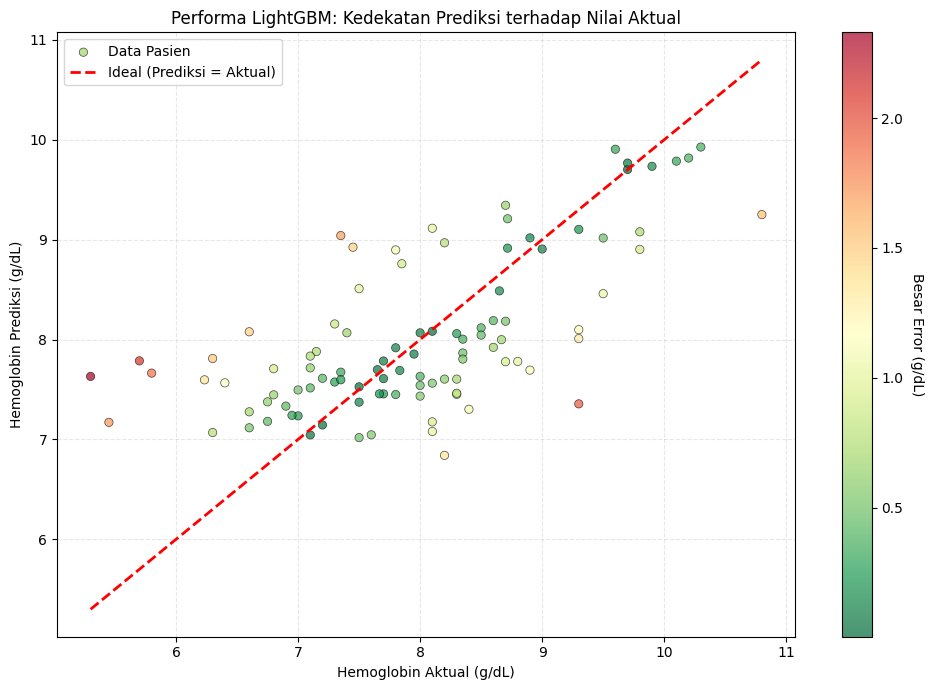

In [44]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = models_final["LightGBM"].predict(X_test)
error_abs = np.abs(y_test - y_pred)

plt.figure(figsize=(10, 7))

# hijau untuk error kecil, merah untuk error besar)
scatter = plt.scatter(y_test, y_pred, 
                      c=error_abs, 
                      cmap='RdYlGn_r', 
                      alpha=0.7, 
                      edgecolors='k', 
                      linewidths=0.5,
                      label='Data Pasien')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Ideal (Prediksi = Aktual)')

cbar = plt.colorbar(scatter)
cbar.set_label('Besar Error (g/dL)', rotation=270, labelpad=15)

plt.xlabel("Hemoglobin Aktual (g/dL)")
plt.ylabel("Hemoglobin Prediksi (g/dL)")
plt.title("Performa LightGBM: Kedekatan Prediksi terhadap Nilai Aktual")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

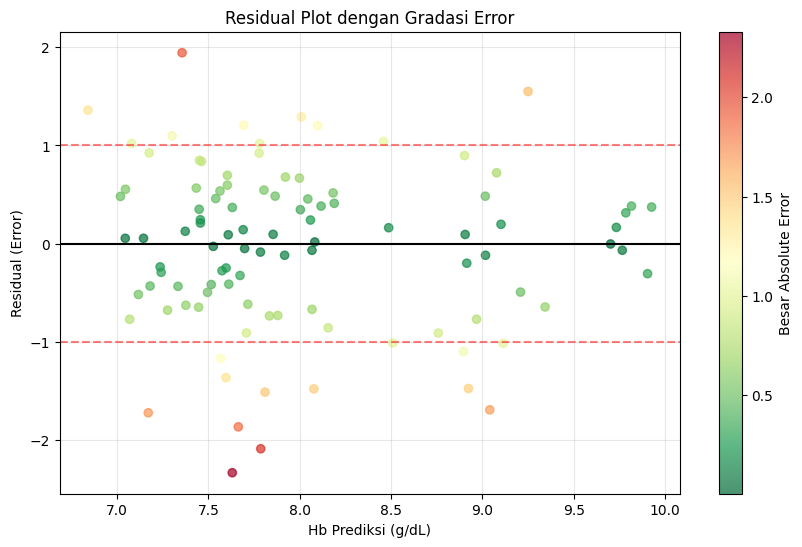

In [45]:
import numpy as np

# Hitung residual dan absolut error
residuals = y_test - y_pred
abs_error = np.abs(residuals)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(y_pred, residuals, c=abs_error, cmap='RdYlGn_r', alpha=0.7)

plt.axhline(y=0, color='black', linestyle='-', linewidth=1.5) # Garis pusat
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)  # Batas error 1.0
plt.axhline(y=-1, color='red', linestyle='--', alpha=0.5) # Batas error -1.0

plt.colorbar(scatter, label='Besar Absolute Error')
plt.xlabel("Hb Prediksi (g/dL)")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot dengan Gradasi Error")
plt.grid(True, alpha=0.3)
plt.show()

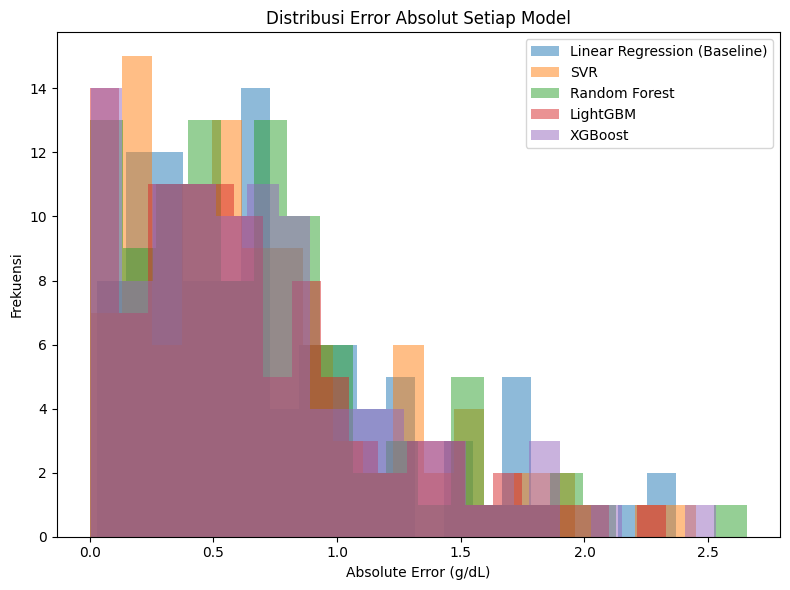

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    abs_error = np.abs(y_test - y_pred)
    
    plt.hist(abs_error, bins=20, alpha=0.5, label=name)

plt.xlabel("Absolute Error (g/dL)")
plt.ylabel("Frekuensi")
plt.title("Distribusi Error Absolut Setiap Model")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Windows\AppData\Local\Temp\ipykernel_16172\3502629487.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors, labels=models_final.keys(), showfliers=False)


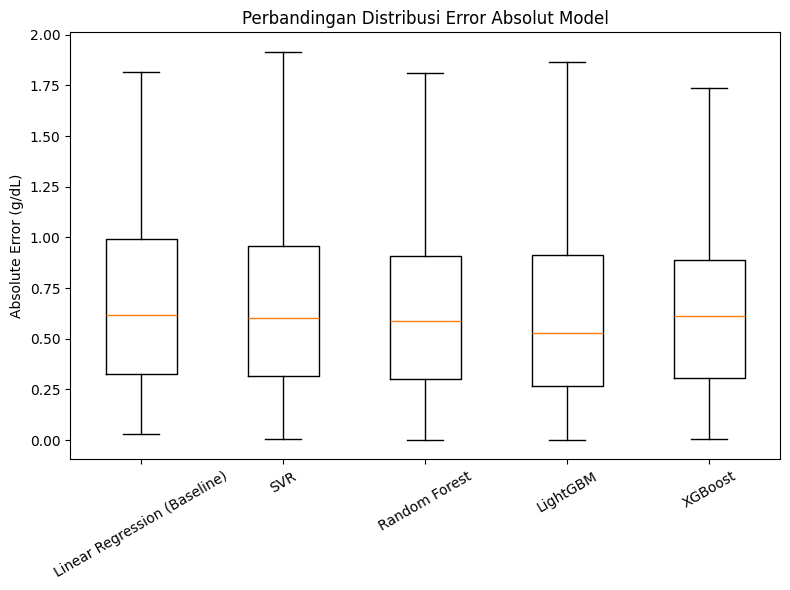

In [47]:
errors = []

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    abs_error = np.abs(y_test - y_pred)
    errors.append(abs_error)

plt.figure(figsize=(8,6))
plt.boxplot(errors, labels=models_final.keys(), showfliers=False)
plt.ylabel("Absolute Error (g/dL)")
plt.title("Perbandingan Distribusi Error Absolut Model")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
